## 1 Plots for ACL/LCM PDE's and scan comparison

### 1.2 Make plots and ODR fit

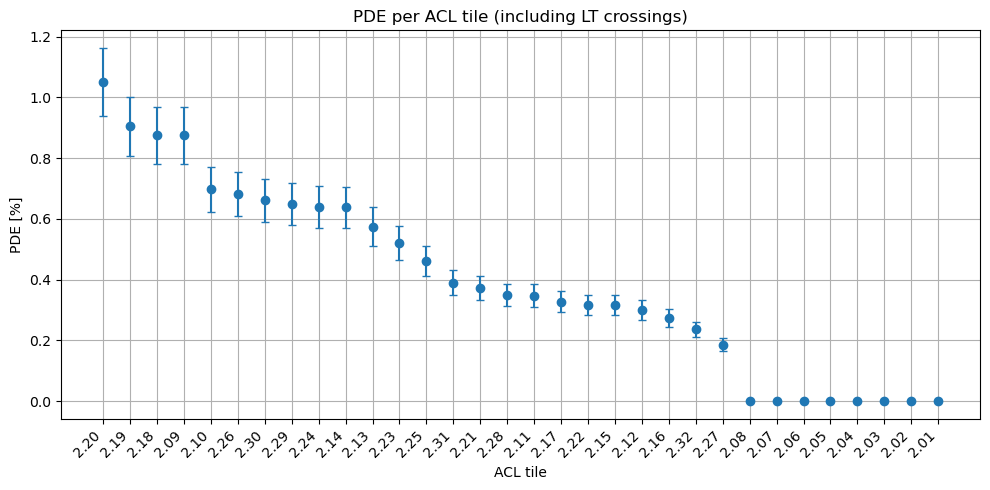

ACL mean PDE: 0.39505783990819765


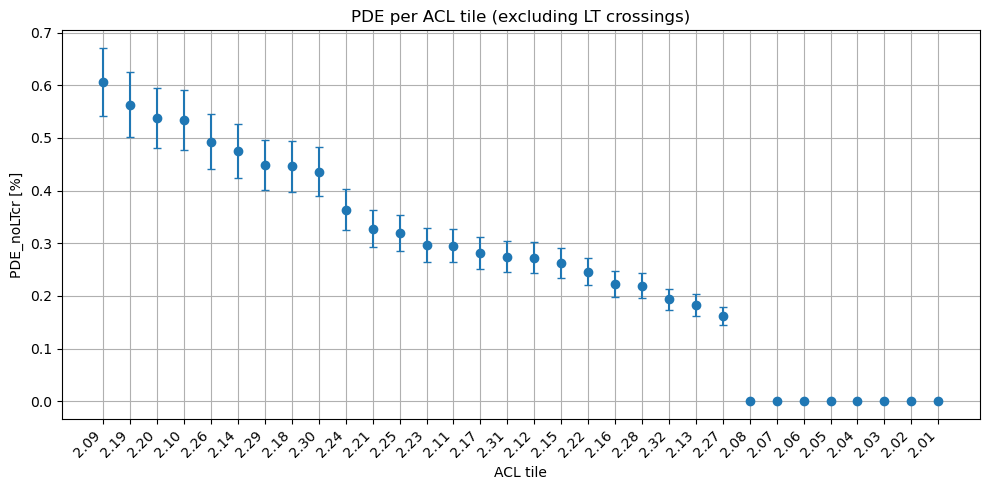

ACL mean PDE_noLTcr: 0.2644519551264972

===== Mean ratio fit =====
Effect of LT-crossing removal on PDE (ACL)
mean value     = 0.709069
chi2           = 89.7159
ndof           = 23
reduced chi2   = 3.90069



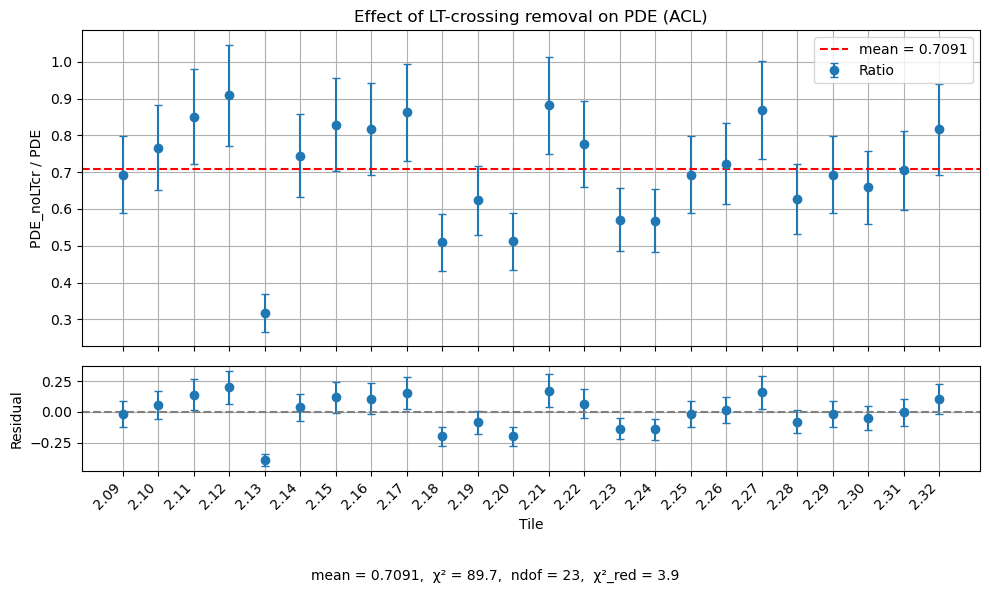

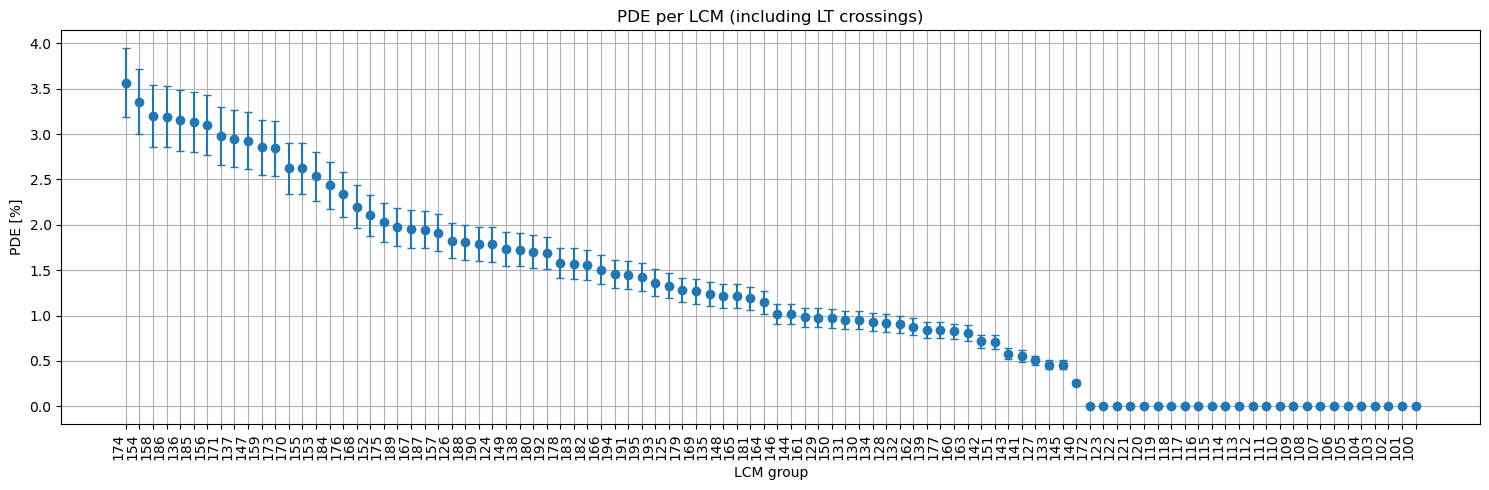

LCM mean PDE: 1.2272530160503219


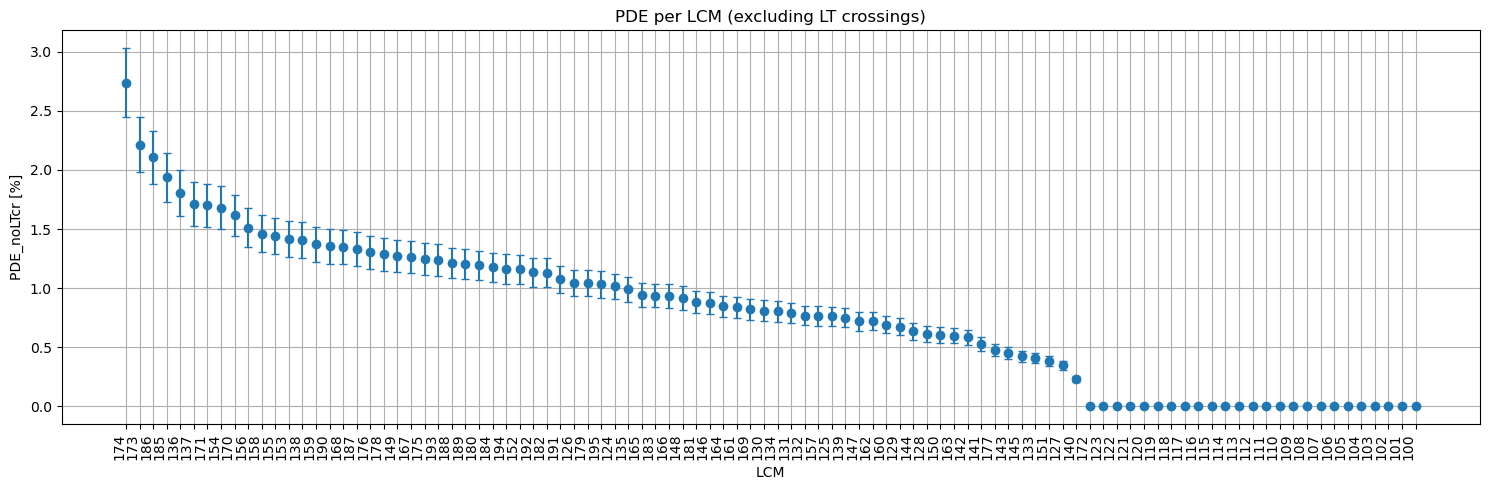

LCM mean PDE_noLTcr: 0.7897679315078615

===== Mean ratio fit =====
Effect of LT-crossing removal on PDE (LCM)
mean value     = 0.688341
chi2           = 266.811
ndof           = 70
reduced chi2   = 3.81159



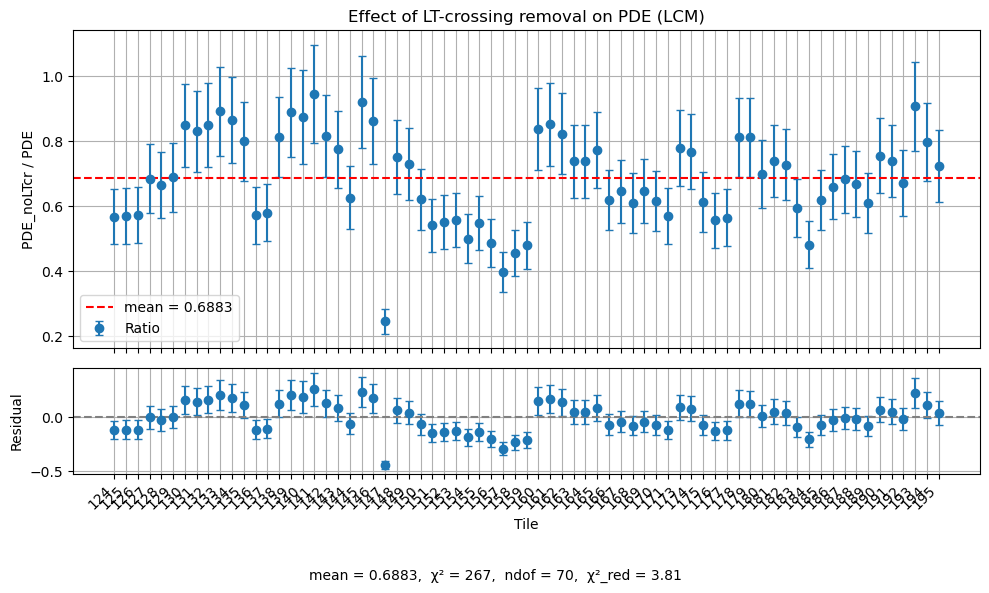

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.odr import Model, RealData, ODR

# =======================================================
# 0) Gain & gate factor uncertainties
# =======================================================

# file = "Gains_FSDrun1_final_1(mean_if_needed).txt"

# # Read file (auto-detect whitespace)
# df_gain = pd.read_csv(file, sep=r"\s+")

# # Convert to numeric (in case some values were read as strings)
# df_gain["Mean_gain"] = pd.to_numeric(df_gain["Mean_gain"], errors="coerce")
# df_gain["Std"]       = pd.to_numeric(df_gain["Std"],   errors="coerce")

# # Remove rows with mean = 0 or NaN
# df_gain = df_gain[df_gain["Mean_gain"] > 0]

# # Compute percentage
# df_gain["std_over_mean_percent"] = df_gain["Std"] / df_gain["Mean_gain"]

# # Find max relative std
# max_idx = df_gain["std_over_mean_percent"].astype(float).idxmax()
# max_row = df_gain.loc[max_idx]

# gatefactor = 0.9674 +- 0.0329
gf   = 0.9674
s_gf = 0.0329

s_gf_perc   = s_gf / gf
s_gain_perc = 0.1# float(max_row["std_over_mean_percent"])

# =======================================================
# 1) Read the PDE CSV
# =======================================================

df = pd.read_csv("pde_sum_all_files_with_names_newlight.csv")

# -------------------- ACL ------------------------------
df_acl = df[df["trap_name"].str.startswith("ACL ", na=False)].copy()

# Strip "ACL " (prefix + space) from trap_name → e.g. "ACL 4.24" → "4.24"
df_acl["trap_name_clean"] = df_acl["trap_name"].str.replace(r"^ACL\s+", "", regex=True)

trap_name_acl       = df_acl["trap_name_clean"].to_numpy()
PE_meas_acl         = df_acl["PE_meas"].to_numpy()        / gf
PE_meas_noLTcr_acl  = df_acl["PE_meas_noLTcr"].to_numpy() / gf
PE_exp_acl          = df_acl["PE_exp"].to_numpy()
PE_exp_noLTcr_acl   = df_acl["PE_exp_noLTcr"].to_numpy()


# -------------------- LCM ------------------------------
df_lcm = df[df["trap_name"].str.startswith("LCM ", na=False)].copy()

def parse_lcm_numbers(name: str):
    """
    From 'LCM 49, 50, 51' or 'LCM 49,50,51' -> ['49', '50', '51']
    """
    rest = name.split(" ", 1)[1]  # part after 'LCM '
    rest = rest.replace(",", " ")
    parts = [p for p in rest.split() if p]
    return parts[:3]  # first up to 3 numbers

df_lcm = df_lcm.sort_values(["trap_name"]).copy()

def assign_lcm_labels(group):
    labels = parse_lcm_numbers(group.name)
    group = group.copy()
    for i, (idx, _) in enumerate(group.iloc[:len(labels)].iterrows()):
        group.loc[idx, "lcm_label"] = labels[i]
    return group

lcm_labeled = df_lcm.groupby("trap_name", group_keys=False).apply(
    assign_lcm_labels, include_groups=False
)
lcm_labeled = lcm_labeled.dropna(subset=["lcm_label"])

trap_name_lcm       = lcm_labeled["lcm_label"].to_numpy()
PE_meas_lcm         = lcm_labeled["PE_meas"].to_numpy()        / gf
PE_meas_noLTcr_lcm  = lcm_labeled["PE_meas_noLTcr"].to_numpy() / gf
PE_exp_lcm          = lcm_labeled["PE_exp"].to_numpy()
PE_exp_noLTcr_lcm   = lcm_labeled["PE_exp_noLTcr"].to_numpy()


# =======================================================
# 2) Read the scan CSV
# =======================================================

# df_scan = pd.read_csv("sum_new_setup2.csv")
# df_scan = df_scan.dropna(subset=["Name"])

# # Extract the "4p16" part and turn it into "4.16"
# labeltag_scan = (
#     df_scan["Name"]
#     .str.extract(r'_(\d+p\d+)_')[0]  # "4p16"
#     .str.replace("p", ".", n=1)     # → "4.16"
#     .to_numpy()
# )

# PE_scan        = df_scan["p.e."].to_numpy()
# PE_uncert_scan = 6

# # Example sigma definition
# sigma_PE_scan = np.sqrt(PE_scan + (PE_scan * (PE_uncert_scan) / 100)**2)

# =======================================================
# 3) PDE & Uncertainties
# =======================================================

# ---------- ACL ----------

PDE_acl = np.divide(
    100 * PE_meas_acl,
    PE_exp_acl,
    out=np.zeros_like(PE_meas_acl, dtype=float),
    where=PE_exp_acl != 0
)

PDE_noLTcr_acl = np.divide(
    100 * PE_meas_noLTcr_acl,
    PE_exp_noLTcr_acl,
    out=np.zeros_like(PE_meas_noLTcr_acl, dtype=float),
    where=PE_exp_noLTcr_acl != 0
)


sigma_PDE_acl = np.divide(
    100 * np.sqrt(
        np.abs(PE_meas_acl) +
        (PE_meas_acl * s_gain_perc)**2 +
        (PE_meas_acl * s_gf_perc)**2
    ),
    PE_exp_acl,
    out=np.zeros_like(PE_meas_acl, dtype=float),
    where=PE_exp_acl != 0
)

sigma_PDE_noLTcr_acl = np.divide(
    100 * np.sqrt(
        np.abs(PE_meas_noLTcr_acl) +
        (PE_meas_noLTcr_acl * s_gain_perc)**2 +
        (PE_meas_noLTcr_acl * s_gf_perc)**2
    ),
    PE_exp_noLTcr_acl,
    out=np.zeros_like(PE_meas_noLTcr_acl, dtype=float),
    where=PE_exp_noLTcr_acl != 0
)


# ---------- LCM ----------
PDE_lcm = np.divide(
    100 * PE_meas_lcm,
    PE_exp_lcm,
    out=np.zeros_like(PE_meas_lcm, dtype=float),
    where=PE_exp_lcm != 0
)

PDE_noLTcr_lcm = np.divide(
    100 * PE_meas_noLTcr_lcm,
    PE_exp_noLTcr_lcm,
    out=np.zeros_like(PE_meas_noLTcr_lcm, dtype=float),
    where=PE_exp_noLTcr_lcm != 0
)


sigma_PDE_lcm = np.divide(
    100 * np.sqrt(
        np.abs(PE_meas_lcm) +
        (PE_meas_lcm * s_gain_perc)**2 +
        (PE_meas_lcm * s_gf_perc)**2
    ),
    PE_exp_lcm,
    out=np.zeros_like(PE_meas_lcm, dtype=float),
    where=PE_exp_lcm != 0
)

sigma_PDE_noLTcr_lcm = np.divide(
    100 * np.sqrt(
        np.abs(PE_meas_noLTcr_lcm) +
        (PE_meas_noLTcr_lcm * s_gain_perc)**2 +
        (PE_meas_noLTcr_lcm * s_gf_perc)**2
    ),
    PE_exp_noLTcr_lcm,
    out=np.zeros_like(PE_meas_noLTcr_lcm, dtype=float),
    where=PE_exp_noLTcr_lcm != 0
)


# =======================================================
# 4) Helper plotting functions
# =======================================================

# res calculation like normal fit
def odr_fit_with_plot(
    x, y, sx, sy, labels,
    ylabel="PDE [%]",
    title="PE vs PDE",
    CI=1
):
    """
    ODR linear fit y = m x + c with uncertainties in x and y.
    Plots:
      - data with error bars
      - best-fit line
      - CI * sigma band
      - residuals subplot
    Also prints and displays reduced chi-square.
    """
    x, y, sx, sy, labels = map(np.array, (x, y, sx, sy, labels))

    mask = (
        np.isfinite(x) & np.isfinite(y) &
        np.isfinite(sx) & np.isfinite(sy) &
        (sx > 0) & (sy > 0)
    )
    x, y, sx, sy, labels = x[mask], y[mask], sx[mask], sy[mask], labels[mask]

    # --- ODR setup ---
    def lin_model(B, xx):
        return B[0]*xx + B[1]

    data  = RealData(x, y, sx=sx, sy=sy)
    model = Model(lin_model)

    m_init = np.polyfit(x, y, 1)[0] if len(x) > 1 else 1.0

    odr = ODR(data, model, beta0=[m_init, 0.0])
    out = odr.run()

    m, c      = out.beta
    dm, dc    = out.sd_beta
    cov_beta  = out.cov_beta * out.res_var  # parameter covariance matrix

    # Chi-square and reduced chi-square
    chi2  = out.sum_square
    N     = len(x)                 # number of data points
    n_par = len(out.beta)          # number of fit parameters (2 for m,c)
    dof   = max(N - n_par, 1)      # avoid division by zero
    red_chi2 = chi2 / dof

    # --- Fit curve & CI band ---
    xfit = np.linspace(x.min()*0.95, x.max()*1.05, 400)
    yfit = lin_model(out.beta, xfit)

    # sigma_y^2(x) = x^2 σ_m^2 + σ_c^2 + 2 x Cov(m,c)
    var_yfit = (
        cov_beta[0, 0] * xfit**2 +
        cov_beta[1, 1] +
        2 * cov_beta[0, 1] * xfit
    )
    sigma_yfit = np.sqrt(np.maximum(var_yfit, 0.0))

    # --- Residuals ---
    y_model   = lin_model(out.beta, x)
    residuals = y - y_model

    # --- Plot ---
    fig, (ax, axr) = plt.subplots(
        2, 1, figsize=(7, 7), sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # Top: data + fit + band
    ax.errorbar(x, y, xerr=sx, yerr=sy, fmt="o", capsize=3, label="Data")
    ax.plot(xfit, yfit, color="orange", label="ODR fit")
    ax.fill_between(
        xfit,
        yfit - CI*sigma_yfit,
        yfit + CI*sigma_yfit,
        alpha=0.25,
        color="skyblue",
        label=f"{CI}σ band"
    )

    for xi, yi, lab in zip(x, y, labels):
        ax.text(xi, yi, lab, fontsize=8, ha="left", va="bottom")

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
    ax.legend()

    # Bottom: residuals
    axr.errorbar(x, residuals, yerr=sy, fmt="o", capsize=3)
    axr.axhline(0.0, color="gray", linestyle="--")
    axr.set_xlabel("p.e. from scan")
    axr.set_ylabel("Residual")
    axr.grid(True)

    # Fit summary text
    text = (
        f"Fit: y = m x + c\n"
        f"m = {m:.3g} ± {dm:.3g}\n"
        f"c = {c:.3g} ± {dc:.3g}\n"
        f"χ² = {chi2:.3g},  ndof = {dof},  χ²_red = {red_chi2:.3g}"
    )
    fig.text(0.5, 0.02, text, ha="center", va="bottom")

    print("\n===== ODR fit results =====")
    print(title)
    print(f"m (slope)      = {m:.6g} ± {dm:.6g}")
    print(f"c (intercept)  = {c:.6g} ± {dc:.6g}")
    print(f"chi2           = {chi2:.6g}")
    print(f"ndof           = {dof}")
    print(f"reduced chi2   = {red_chi2:.6g}")
    print("===========================\n")

    plt.tight_layout(rect=[0, 0.06, 1, 1])
    plt.show()


# res calculation perpendicular to fit
def odr_fit_with_plot(
    x, y, sx, sy, labels,
    ylabel="PDE [%]",
    title="PE vs PDE",
    CI=1
):
    """
    ODR linear fit y = m x + c with uncertainties in x and y.

    Plots:
      - data with error bars
      - best-fit line
      - CI * sigma band in y
      - residuals subplot using *perpendicular* distances to the line
        with correctly propagated uncertainties.

    Perpendicular residual for point (x_i, y_i):
        r_perp = (m*x_i + c - y_i) / sqrt(m^2 + 1)

    If x and y are uncorrelated with sigmas sx_i, sy_i, the variance of
    the perpendicular residual is:
        sigma_perp^2 = (m^2 * sx_i^2 + sy_i^2) / (m^2 + 1)
    """
    x, y, sx, sy, labels = map(np.array, (x, y, sx, sy, labels))

    mask = (
        np.isfinite(x) & np.isfinite(y) &
        np.isfinite(sx) & np.isfinite(sy) &
        (sx > 0) & (sy > 0)
    )
    x, y, sx, sy, labels = x[mask], y[mask], sx[mask], sy[mask], labels[mask]

    # --- ODR setup ---
    def lin_model(B, xx):
        return B[0]*xx + B[1]

    data  = RealData(x, y, sx=sx, sy=sy)
    model = Model(lin_model)

    m_init = np.polyfit(x, y, 1)[0] if len(x) > 1 else 1.0

    odr = ODR(data, model, beta0=[m_init, 0.0])
    out = odr.run()

    m, c      = out.beta
    dm, dc    = out.sd_beta
    cov_beta  = out.cov_beta * out.res_var  # parameter covariance matrix

    # Chi-square and reduced chi-square from ODR
    chi2  = out.sum_square
    N     = len(x)                 # number of data points
    n_par = len(out.beta)          # 2 parameters (m, c)
    dof   = max(N - n_par, 1)
    red_chi2 = chi2 / dof

    # --- Fit curve & CI band in y ---
    xfit = np.linspace(x.min()*0.95, x.max()*1.05, 400)
    yfit = lin_model(out.beta, xfit)

    # sigma_y^2(x) = x^2 σ_m^2 + σ_c^2 + 2 x Cov(m,c)
    var_yfit = (
        cov_beta[0, 0] * xfit**2 +
        cov_beta[1, 1] +
        2 * cov_beta[0, 1] * xfit
    )
    sigma_yfit = np.sqrt(np.maximum(var_yfit, 0.0))

    # --- Perpendicular residuals & their uncertainties ---
    # r_perp = (m x + c - y) / sqrt(m^2 + 1)
    denom = np.sqrt(m*m + 1.0)
    y_model       = lin_model(out.beta, x)
    residuals_perp = (y_model - y) / denom

    # sigma_perp^2 = (m^2 sx^2 + sy^2) / (m^2 + 1)
    sigma_res_perp = np.sqrt((m*m * sx**2 + sy**2) / (m*m + 1.0))

    # --- Plot ---
    fig, (ax, axr) = plt.subplots(
        2, 1, figsize=(7, 7), sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # Top: data + fit + CI band
    ax.errorbar(x, y, xerr=sx, yerr=sy, fmt="o", capsize=3, label="Data")
    ax.plot(xfit, yfit, color="orange", label="ODR fit")
    ax.fill_between(
        xfit,
        yfit - CI*sigma_yfit,
        yfit + CI*sigma_yfit,
        alpha=0.25,
        color="skyblue",
        label=f"{CI}σ band"
    )

    for xi, yi, lab in zip(x, y, labels):
        ax.text(xi, yi, lab, fontsize=8, ha="left", va="bottom")

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
    ax.legend()

    # Bottom: perpendicular residuals
    axr.errorbar(
        x, residuals_perp,
        yerr=sigma_res_perp,
        fmt="o", capsize=3
    )
    axr.axhline(0.0, color="gray", linestyle="--")
    axr.set_xlabel("p.e. from scan")
    axr.set_ylabel("⊥ residual")
    axr.grid(True)

    # Fit summary text inside residual panel
    text = (
        f"Fit: y = m x + c\n"
        f"m = {m:.3g} ± {dm:.3g}\n"
        f"c = {c:.3g} ± {dc:.3g}\n"
        f"χ² = {chi2:.3g},  ndof = {dof},  χ²_red = {red_chi2:.3g}"
    )
    axr.text(
        0.02, 0.98, text,
        transform=axr.transAxes,
        ha="left", va="top",
        fontsize=9,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
    )

    print("\n===== ODR fit results (perpendicular residuals) =====")
    print(title)
    print(f"m (slope)      = {m:.6g} ± {dm:.6g}")
    print(f"c (intercept)  = {c:.6g} ± {dc:.6g}")
    print(f"chi2           = {chi2:.6g}")
    print(f"ndof           = {dof}")
    print(f"reduced chi2   = {red_chi2:.6g}")
    print("Note: residuals plotted are perpendicular to the fit line.")
    print("======================================================\n")

    plt.tight_layout()
    plt.show()

# res calculation perpendicular and adjusted label
def odr_fit_with_plot(
    x, y, sx, sy, labels,
    ylabel="PDE [%]",
    title="PE vs PDE",
    CI=1
):
    """
    ODR linear fit y = m x + c with uncertainties in x and y.

    Plots:
      - Top: data with error bars, best-fit line, CI * sigma band in y,
        and a fit summary box in the bottom-right.
      - Bottom: residuals subplot using *perpendicular* distances to the line
        with correctly propagated uncertainties.

    Perpendicular residual for point (x_i, y_i):
        r_perp = (m*x_i + c - y_i) / sqrt(m^2 + 1)

    If x and y are uncorrelated with sigmas sx_i, sy_i, the variance of
    the perpendicular residual is:
        sigma_perp^2 = (m^2 * sx_i^2 + sy_i^2) / (m^2 + 1)
    """
    # Convert to numpy arrays
    x, y, sx, sy, labels = map(np.array, (x, y, sx, sy, labels))

    # Clean data: finite values and positive uncertainties
    mask = (
        np.isfinite(x) & np.isfinite(y) &
        np.isfinite(sx) & np.isfinite(sy) &
        (sx > 0) & (sy > 0)
    )
    x, y, sx, sy, labels = x[mask], y[mask], sx[mask], sy[mask], labels[mask]

    # --- ODR setup ---
    def lin_model(B, xx):
        return B[0]*xx + B[1]

    data  = RealData(x, y, sx=sx, sy=sy)
    model = Model(lin_model)

    # Initial guess from simple linear regression (slope only)
    m_init = np.polyfit(x, y, 1)[0] if len(x) > 1 else 1.0

    odr = ODR(data, model, beta0=[m_init, 0.0])
    out = odr.run()

    # Fit parameters and their uncertainties
    m, c      = out.beta
    dm, dc    = out.sd_beta
    cov_beta  = out.cov_beta * out.res_var  # parameter covariance matrix

    # Chi-square and reduced chi-square from ODR
    chi2  = out.sum_square
    N     = len(x)                 # number of data points
    n_par = len(out.beta)          # 2 parameters (m, c)
    dof   = max(N - n_par, 1)
    red_chi2 = chi2 / dof

    # --- Fit curve & CI band in y ---
    xfit = np.linspace(x.min()*0.95, x.max()*1.05, 400)
    yfit = lin_model(out.beta, xfit)

    # sigma_y^2(x) = x^2 σ_m^2 + σ_c^2 + 2 x Cov(m,c)
    var_yfit = (
        cov_beta[0, 0] * xfit**2 +
        cov_beta[1, 1] +
        2 * cov_beta[0, 1] * xfit
    )
    sigma_yfit = np.sqrt(np.maximum(var_yfit, 0.0))

    # --- Perpendicular residuals & their uncertainties ---
    # r_perp = (m x + c - y) / sqrt(m^2 + 1)
    denom = np.sqrt(m*m + 1.0)
    y_model        = lin_model(out.beta, x)
    residuals_perp = (y_model - y) / denom

    # sigma_perp^2 = (m^2 sx^2 + sy^2) / (m^2 + 1)
    sigma_res_perp = np.sqrt((m*m * sx**2 + sy**2) / (m*m + 1.0))

    # --- Plot ---
    fig, (ax, axr) = plt.subplots(
        2, 1, figsize=(7, 7), sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # Top: data + fit + CI band
    ax.errorbar(x, y, xerr=sx, yerr=sy, fmt="o", capsize=3, label="Data")
    ax.plot(xfit, yfit, color="orange", label="ODR fit")
    ax.fill_between(
        xfit,
        yfit - CI*sigma_yfit,
        yfit + CI*sigma_yfit,
        alpha=0.25,
        color="skyblue",
        label=f"{CI}σ band"
    )

    # Annotate points with labels
    for xi, yi, lab in zip(x, y, labels):
        ax.text(xi, yi, lab, fontsize=8, ha="left", va="bottom")

    # Fit summary box in upper plot, bottom-right
    fit_label = (
        f"m = {m:.3g} ± {dm:.3g}\n"
        f"c = {c:.3g} ± {dc:.3g}\n"
        f"χ²_red = {red_chi2:.3g}"
    )
    ax.text(
        0.98, 0.02, fit_label,
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=9,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.75)
    )

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
    ax.legend()

    # Bottom: perpendicular residuals
    axr.errorbar(
        x, residuals_perp,
        yerr=sigma_res_perp,
        fmt="o", capsize=3
    )
    axr.axhline(0.0, color="gray", linestyle="--")
    axr.set_xlabel("p.e. from scan")
    axr.set_ylabel("⊥ residual")
    axr.grid(True)

    print("\n===== ODR fit results (perpendicular residuals) =====")
    print(title)
    print(f"m (slope)      = {m:.6g} ± {dm:.6g}")
    print(f"c (intercept)  = {c:.6g} ± {dc:.6g}")
    print(f"chi2           = {chi2:.6g}")
    print(f"ndof           = {dof}")
    print(f"reduced chi2   = {red_chi2:.6g}")
    print("Note: residuals plotted are perpendicular to the fit line.")
    print("======================================================\n")

    plt.tight_layout()
    plt.show()



def plot_ratio_with_residuals(
    names, ratio, sigma_ratio,
    title="Ratio plot",
    ylabel="PDE_noLTcr / PDE"
):
    """
    Plot ratio with error bars, mean as dashed line,
    and residuals in a subplot.
    Also shows reduced chi-square of the (constant) mean fit.
    """
    names       = np.array(names)
    ratio       = np.array(ratio, dtype=float)
    sigma_ratio = np.array(sigma_ratio, dtype=float)

    mask = np.isfinite(ratio) & np.isfinite(sigma_ratio) & (sigma_ratio > 0)
    names, ratio, sigma_ratio = names[mask], ratio[mask], sigma_ratio[mask]

    x = np.arange(len(names))
    mean_val = np.nanmean(ratio)  # simple mean

    # Chi-square for constant (mean) model
    chi2 = np.sum(((ratio - mean_val) / sigma_ratio)**2)
    dof  = len(ratio) - 1
    red_chi2 = chi2 / dof if dof > 0 else np.nan

    fig, (ax, axr) = plt.subplots(
        2, 1, figsize=(10, 6), sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # Top: ratio + mean
    ax.errorbar(x, ratio, yerr=sigma_ratio, fmt="o", capsize=3, label="Ratio")
    ax.axhline(mean_val, color="red", linestyle="--",
               label=f"mean = {mean_val:.4f}")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
    ax.legend()

    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha="right")

    # Bottom: residuals
    residuals = ratio - mean_val
    axr.errorbar(x, residuals, yerr=sigma_ratio, fmt="o", capsize=3)
    axr.axhline(0.0, color="gray", linestyle="--")
    axr.set_xlabel("Tile")
    axr.set_ylabel("Residual")
    axr.set_xticks(x)
    axr.set_xticklabels(names, rotation=45, ha="right")
    axr.grid(True)

    fig.text(
        0.5, 0.02,
        f"mean = {mean_val:.4f},  χ² = {chi2:.3g},  ndof = {dof},  χ²_red = {red_chi2:.3g}",
        ha="center", va="bottom"
    )

    print("\n===== Mean ratio fit =====")
    print(title)
    print(f"mean value     = {mean_val:.6g}")
    print(f"chi2           = {chi2:.6g}")
    print(f"ndof           = {dof}")
    print(f"reduced chi2   = {red_chi2:.6g}")
    print("==========================\n")

    plt.tight_layout(rect=[0, 0.08, 1, 1])
    plt.show()


# =======================================================
# 5) ACL PDE Plots
# =======================================================

idx_acl = np.argsort(PDE_acl)[::-1]

plt.figure(figsize=(10, 5))
plt.errorbar(
    trap_name_acl[idx_acl],
    PDE_acl[idx_acl],
    yerr=sigma_PDE_acl[idx_acl],
    fmt="o",
    capsize=3
)
plt.xticks(rotation=45, ha="right")
plt.xlabel("ACL tile")
plt.ylabel("PDE [%]")
plt.title("PDE per ACL tile (including LT crossings)")
plt.tight_layout()
plt.grid(True)
plt.show()

print("ACL mean PDE:", np.nanmean(PDE_acl))

idx_acl_noLT = np.argsort(PDE_noLTcr_acl)[::-1]

plt.figure(figsize=(10, 5))
plt.errorbar(
    trap_name_acl[idx_acl_noLT],
    PDE_noLTcr_acl[idx_acl_noLT],
    yerr=sigma_PDE_noLTcr_acl[idx_acl_noLT],
    fmt="o",
    capsize=3
)
plt.xticks(rotation=45, ha="right")
plt.xlabel("ACL tile")
plt.ylabel("PDE_noLTcr [%]")
plt.title("PDE per ACL tile (excluding LT crossings)")
plt.tight_layout()
plt.grid(True)
plt.show()

print("ACL mean PDE_noLTcr:", np.nanmean(PDE_noLTcr_acl))

# =======================================================
# 6) ACL Ratio + residuals (mean fit)
# =======================================================

ratio_acl = np.divide(
    PDE_noLTcr_acl,
    PDE_acl,
    out=np.zeros_like(PDE_noLTcr_acl, dtype=float),
    where=PDE_acl != 0
)

term = np.divide(
    PDE_noLTcr_acl * sigma_PDE_acl,
    PDE_acl,
    out=np.zeros_like(PDE_acl, dtype=float),
    where=PDE_acl != 0
)

numerator = np.sqrt(
    sigma_PDE_noLTcr_acl**2 +
    term**2
)

sigma_ratio_acl = np.divide(
    numerator,
    PDE_acl,
    out=np.zeros_like(numerator, dtype=float),
    where=PDE_acl != 0
)


plot_ratio_with_residuals(
    trap_name_acl, ratio_acl, sigma_ratio_acl,
    title="Effect of LT-crossing removal on PDE (ACL)",
    ylabel="PDE_noLTcr / PDE"
)

# =======================================================
# 7) LCM PDE & Ratio plots
# =======================================================

idx_lcm = np.argsort(PDE_lcm)[::-1]

plt.figure(figsize=(15, 5))
plt.errorbar(
    trap_name_lcm[idx_lcm],
    PDE_lcm[idx_lcm],
    yerr=sigma_PDE_lcm[idx_lcm],
    fmt="o",
    capsize=3
)
plt.xticks(rotation=90, ha="right")
plt.xlabel("LCM")
plt.ylabel("PDE [%]")
plt.title("PDE per LCM (including LT crossings)")
plt.tight_layout()
plt.grid(True)
plt.show()

print("LCM mean PDE:", np.nanmean(PDE_lcm))

idx_lcm_noLT = np.argsort(PDE_noLTcr_lcm)[::-1]

plt.figure(figsize=(15, 5))
plt.errorbar(
    trap_name_lcm[idx_lcm_noLT],
    PDE_noLTcr_lcm[idx_lcm_noLT],
    yerr=sigma_PDE_noLTcr_lcm[idx_lcm_noLT],
    fmt="o",
    capsize=3
)
plt.xticks(rotation=90, ha="right")
plt.xlabel("LCM")
plt.ylabel("PDE_noLTcr [%]")
plt.title("PDE per LCM (excluding LT crossings)")
plt.tight_layout()
plt.grid(True)
plt.show()

print("LCM mean PDE_noLTcr:", np.nanmean(PDE_noLTcr_lcm))

# LCM ratios
ratio_lcm = np.divide(
    PDE_noLTcr_lcm,
    PDE_lcm,
    out=np.zeros_like(PDE_noLTcr_lcm, dtype=float),
    where=PDE_lcm != 0
)

term = np.divide(
    PDE_noLTcr_lcm * sigma_PDE_lcm,
    PDE_lcm,
    out=np.zeros_like(PDE_lcm, dtype=float),
    where=PDE_lcm != 0
)

numerator = np.sqrt(
    sigma_PDE_noLTcr_lcm**2 +
    term**2
)

sigma_ratio_lcm = np.divide(
    numerator,
    PDE_lcm,
    out=np.zeros_like(numerator, dtype=float),
    where=PDE_lcm != 0
)


plot_ratio_with_residuals(
    trap_name_lcm, ratio_lcm, sigma_ratio_lcm,
    title="Effect of LT-crossing removal on PDE (LCM)",
    ylabel="PDE_noLTcr / PDE"
)

# =======================================================
# 8) Matching ACL tiles to scan labels
# =======================================================

# acl_nums  = np.array([float(t) for t in trap_name_acl])
# scan_nums = np.array([float(s) for s in labeltag_scan])

# matched_scan_PE        = []
# matched_PDE            = []
# matched_PDE_noLT       = []
# matched_sigma_PE       = []
# matched_sigma_PDE      = []
# matched_sigma_PDE_noLT = []
# matched_labels         = []

# for val in scan_nums:
#     ix_acl  = np.where(acl_nums == val)[0]
#     ix_scan = np.where(scan_nums == val)[0]
#     if len(ix_acl) > 0 and len(ix_scan) > 0:
#         i_acl  = ix_acl[0]
#         i_scan = ix_scan[0]

#         matched_scan_PE.append(PE_scan[i_scan])
#         matched_sigma_PE.append(sigma_PE_scan[i_scan])

#         matched_PDE.append(PDE_acl[i_acl])
#         matched_sigma_PDE.append(sigma_PDE_acl[i_acl])

#         matched_PDE_noLT.append(PDE_noLTcr_acl[i_acl])
#         matched_sigma_PDE_noLT.append(sigma_PDE_noLTcr_acl[i_acl])

#         matched_labels.append(trap_name_acl[i_acl])

# matched_scan_PE        = np.array(matched_scan_PE)
# matched_PDE            = np.array(matched_PDE)
# matched_PDE_noLT       = np.array(matched_PDE_noLT)
# matched_sigma_PE       = np.array(matched_sigma_PE)
# matched_sigma_PDE      = np.array(matched_sigma_PDE)
# matched_sigma_PDE_noLT = np.array(matched_sigma_PDE_noLT)
# matched_labels         = np.array(matched_labels)

# =======================================================
# 9) ODR fits: PE vs PDE (with & without LT crossings)
#     -> CI can be 1, 2, 3, ...
# =======================================================

# odr_fit_with_plot(
#     matched_scan_PE,
#     matched_PDE,
#     matched_sigma_PE,
#     matched_sigma_PDE,
#     matched_labels,
#     ylabel="PDE [%]",
#     title="PE vs PDE per ACL tile (with LT crossings)",
#     CI=1
# )

# odr_fit_with_plot(
#     matched_scan_PE,
#     matched_PDE_noLT,
#     matched_sigma_PE,
#     matched_sigma_PDE_noLT,
#     matched_labels,
#     ylabel="PDE_noLTcr [%]",
#     title="PE vs PDE per ACL tile (no LT crossings)",
#     CI=1
# )

# note: LTs with dead channels are LCM:55,56,57; ACL:4.02,4.22
